# 현재 작업중. 10월 31일 발표 시간 전에 완성하여 업로드 예정.
<br>
<br>
<br>
<br>
<br>


## learning-AI : deep learning application (61357002)
### PT : MNIST GAN

**MNIST 데이터셋을 이용하여 GAN 실습**

<br>

- **임규연 (lky473736)**
- 2024.10.30.에 문서 작성
- **Reference**
    - https://github.com/shinyflight/Simple-GAN-TensorFlow-2.0/blob/master/GAN.py
    - https://ddongwon.tistory.com/124
    - https://colab.research.google.com/drive/12CqGv89Z14jXR5RHLFI9XAEXQ4YhlK5R?source=post_page-----a073a5425ef2--------------------------------#scrollTo=a891995d-3de8-45a7-b88c-4a24a65a4547
   

## <span id='dl'><mark>DL</mark></span>

MNIST dataset을 이용하여 적대적 생성 신경망인 **GAN : Generative Adversarial Networks을 실습**해본다. GAN은 두 개의 신경망, 즉 **생성기(Generator)와 판별기(Discriminator)로 구성**되어 있다. 생성기는 랜덤 노이즈(z)를 입력으로 받아 가짜 이미지를 생성하는 역할을 하며, 그 목표는 판별기를 속일 수 있는 진짜 같은 이미지를 만들어내는 것이다. 반면, 판별기는 진짜 이미지와 생성기가 만든 가짜 이미지를 입력받아 이들이 진짜인지 가짜인지 구별하는 역할을 하며, 진짜와 가짜 이미지를 정확히 분류하는 것이 목표이다.



In [1]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from scipy.stats import skew
import os
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import numpy as np
import scipy
from tqdm import tqdm

2024-10-30 15:14:40.646130: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from keras.utils import to_categorical

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LeakyReLU, Reshape, Flatten
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam


-----

### GAN

<img src="https://media.licdn.com/dms/image/D5612AQHkJCQXbWOMaQ/article-cover_image-shrink_600_2000/0/1682400466378?e=2147483647&v=beta&t=x7lcQ2xx6gWaS0HPnftVbspyA8fTQXivsEf5_q9gAig" width="500px">

GAN의 작동 순서는 Generator가 랜덤 노이즈를 입력받아 가짜 이미지를 생성하고, 이를 Discriminator에 전달하여 진짜와 가짜를 구분하는 방식으로 동작한다. Discriminator는 실제 이미지와 생성된 가짜 이미지를 입력받아 이진 분류를 수행하며, 이 과정에서 두 네트워크가 서로 경쟁하며 발전하는 구조이다.

Generator는 기본적으로 Decoder 구조와 유사한 형태를 가지는데, 저차원의 랜덤 노이즈를 입력받아 Dense layer를 통해 특징을 확장하고 upsampling 과정을 거쳐 고차원의 이미지를 생성한다. 이 과정에서 tf.keras.layers의 Dense, Conv2DTranspose, BatchNormalization, LeakyReLU가 주로 사용되며, 마지막 출력층에는 Tanh 활성화 함수를 적용한다.

Discriminator는 Encoder 구조와 유사하게 구성되며, 고차원의 이미지를 입력받아 Conv2D layer를 통해 특징을 추출하고 점차 차원을 축소하여 최종적으로 이진 분류를 수행한다. tf.keras.layers의 Conv2D, BatchNormalization, LeakyReLU, Dropout이 주로 사용되며, 마지막 층에는 Dense layer와 Sigmoid 활성화 함수를 통해 진짜/가짜 확률을 출력한다. 이러한 구조는 기본적인 Autoencoder에서 Encoder 부분과 유사한 형태를 보이지만, 목적함수와 학습 방식에서 차이가 있다.

여기서는 **Dense layer (full connected layer)만을 이용하여 구성한다. 추후 CGAN, DCGAN을 다른 노트북 파일에서 작업한다.**

In [5]:
# 데이터셋 로드
(X_train, _), (_, _) = mnist.load_data()
X_train = X_train / 255.0  # 정규화
X_train = np.expand_dims(X_train, axis=-1)  # 차원 추가
# X_train의 형태: (60000, 28, 28, 1)


In [6]:
# 하이퍼파라미터
latent_dim = 100  # 잠재 공간 차원
epochs = 1000
batch_size = 128


In [7]:
# 생성자 모델
def build_generator():
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim))
    model.add(BatchNormalization())
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Dense(28 * 28, activation='tanh'))
    model.add(Reshape((28, 28, 1)))
    return model


In [8]:
# 판별자 모델
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28, 1)))
    model.add(Dense(512))
    model.add(Dropout(0.3))
    model.add(Dense(256))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    return model


In [9]:
generator = build_generator()
discriminator = build_discriminator()

discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# GAN 모델 설정
discriminator.trainable = False
gan_input = Sequential()
gan_input.add(generator)
gan_input.add(discriminator)
gan_input.compile(loss='binary_crossentropy', optimizer=Adam())

In [11]:
# 이미지 저장 및 실시간 표시 함수
def save_and_show_generated_images(epoch):
    noise = np.random.normal(0, 1, size=[10, latent_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(10, 28, 28)

    # 이미지를 저장
    plt.figure(figsize=(10, 1))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')

    # 현재 에폭 표시
    plt.suptitle(f'Epoch: {epoch + 1}', fontsize=16)
    plt.savefig(f'gan_generated_epoch_{epoch}.png')
    plt.close()

    # 실시간으로 이미지 보여주기
    plt.figure(figsize=(10, 1))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')

    # 현재 에폭 표시
    plt.suptitle(f'Epoch: {epoch + 1}', fontsize=16)
    plt.show()
    plt.pause(0.001)  # 잠깐 대기하여 이미지 업데이트
    print(f'Epoch: {epoch + 1}/{epochs}, D Loss: {d_loss[0]}, G Loss: {g_loss}')



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


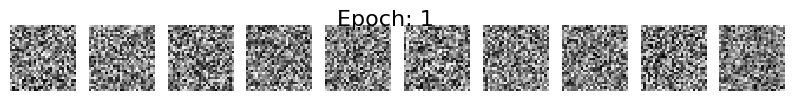

Epoch: 1/1000, D Loss: 0.7627930641174316, G Loss: [array(0.8054795, dtype=float32), array(0.8054795, dtype=float32), array(0.484375, dtype=float32)]
Epoch: 1/1000, D Loss: 0.7627930641174316, G Loss: [array(0.8054795, dtype=float32), array(0.8054795, dtype=float32), array(0.484375, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 2/1000, D Loss: 0.7949626445770264, G Loss: [array(0.81456244, dtype=float32), array(0.81456244, dtype=float32), array(0.5097656, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch: 3/1000, D Loss: 0.8194802403450012, G Loss: [array(0.8390713, dtype=float32), array(0.8390713, dtype=float32), array(0.5026042, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch: 4/1000, D Loss: 0.8324862718582153, G Loss: [array(0.8461931, dtype=float32), array(0.8461931, dtype=float32), array(0.49804688, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch: 5/1000, D Loss: 0.8407070636749268, G Loss: [array(0.8574438, dtype=float32), array(0

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 31/1000, D Loss: 1.0150551795959473, G Loss: [array(1.019738, dtype=float32), array(1.019738, dtype=float32), array(0.45123488, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 32/1000, D Loss: 1.0215086936950684, G Loss: [array(1.0289955, dtype=float32), array(1.0289955, dtype=float32), array(0.44970703, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 33/1000, D Loss: 1.0312174558639526, G Loss: [array(1.0373504, dtype=float32), array(1.0373504, dtype=float32), array(0.4466146, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 34/1000, D Loss: 1.0383305549621582, G Loss: [array(1.0443912, dtype=float32), array(1.0443912, dtype=float32), array(0.4453125, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 35/1000, D Loss: 1.0448951721191406, G Loss: [array(1.0507486, dtype=float32), array(1.0507486, dtype=float32), array(0.4453125, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 36/10

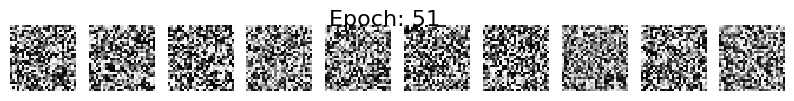

Epoch: 51/1000, D Loss: 1.228785753250122, G Loss: [array(1.2370833, dtype=float32), array(1.2370833, dtype=float32), array(0.40732232, dtype=float32)]
Epoch: 51/1000, D Loss: 1.228785753250122, G Loss: [array(1.2370833, dtype=float32), array(1.2370833, dtype=float32), array(0.40732232, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch: 52/1000, D Loss: 1.2424782514572144, G Loss: [array(1.2528751, dtype=float32), array(1.2528751, dtype=float32), array(0.40489784, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 53/1000, D Loss: 1.2573440074920654, G Loss: [array(1.2669832, dtype=float32), array(1.2669832, dtype=float32), array(0.4030071, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch: 54/1000, D Loss: 1.2726129293441772, G Loss: [array(1.2826688, dtype=float32), array(1.2826688, dtype=float32), array(0.4007523, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 55/1000, D Loss: 1.2871580123901367, G Loss: [array(1.296588, dtype=float32), ar

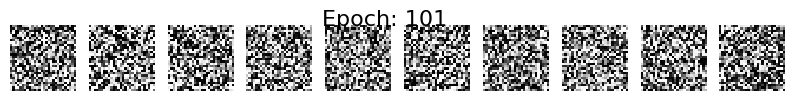

Epoch: 101/1000, D Loss: 2.1538796424865723, G Loss: [array(2.166897, dtype=float32), array(2.166897, dtype=float32), array(0.34463954, dtype=float32)]
Epoch: 101/1000, D Loss: 2.1538796424865723, G Loss: [array(2.166897, dtype=float32), array(2.166897, dtype=float32), array(0.34463954, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch: 102/1000, D Loss: 2.172532320022583, G Loss: [array(2.1854155, dtype=float32), array(2.1854155, dtype=float32), array(0.34401807, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch: 103/1000, D Loss: 2.190770149230957, G Loss: [array(2.2034676, dtype=float32), array(2.2034676, dtype=float32), array(0.34356037, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch: 104/1000, D Loss: 2.208871364593506, G Loss: [array(2.2215247, dtype=float32), array(2.2215247, dtype=float32), array(0.3429988, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch: 105/1000, D Loss: 2.227858543395996, G Loss: [array(2.2414463, dtype=float32), 

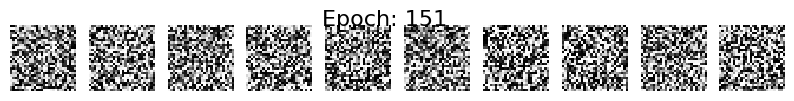

Epoch: 151/1000, D Loss: 2.899374485015869, G Loss: [array(2.909085, dtype=float32), array(2.909085, dtype=float32), array(0.3211662, dtype=float32)]
Epoch: 151/1000, D Loss: 2.899374485015869, G Loss: [array(2.909085, dtype=float32), array(2.909085, dtype=float32), array(0.3211662, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 152/1000, D Loss: 2.911344528198242, G Loss: [array(2.9209692, dtype=float32), array(2.9209692, dtype=float32), array(0.3210064, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 153/1000, D Loss: 2.922761917114258, G Loss: [array(2.9318576, dtype=float32), array(2.9318576, dtype=float32), array(0.32087418, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 154/1000, D Loss: 2.9338531494140625, G Loss: [array(2.94304, dtype=float32), array(2.94304, dtype=float32), array(0.32056615, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 155/1000, D Loss: 2.9447412490844727, G Loss: [array(2.9536195, dtype=float32), array(

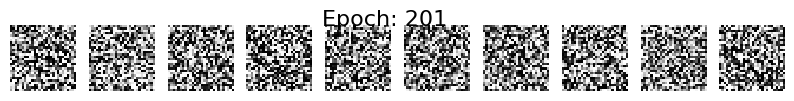

Epoch: 201/1000, D Loss: 3.3702569007873535, G Loss: [array(3.37734, dtype=float32), array(3.37734, dtype=float32), array(0.31168377, dtype=float32)]
Epoch: 201/1000, D Loss: 3.3702569007873535, G Loss: [array(3.37734, dtype=float32), array(3.37734, dtype=float32), array(0.31168377, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch: 202/1000, D Loss: 3.378106117248535, G Loss: [array(3.3855324, dtype=float32), array(3.3855324, dtype=float32), array(0.31157178, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 203/1000, D Loss: 3.3858938217163086, G Loss: [array(3.3929236, dtype=float32), array(3.3929236, dtype=float32), array(0.3114609, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch: 204/1000, D Loss: 3.392897605895996, G Loss: [array(3.3994327, dtype=float32), array(3.3994327, dtype=float32), array(0.31146598, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 205/1000, D Loss: 3.4001963138580322, G Loss: [array(3.4075737, dtype=float32), ar

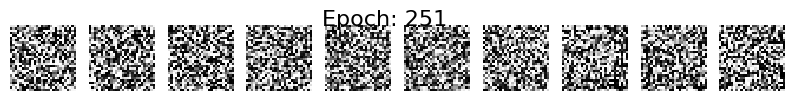

Epoch: 251/1000, D Loss: 3.7020320892333984, G Loss: [array(3.7079391, dtype=float32), array(3.7079391, dtype=float32), array(0.3046564, dtype=float32)]
Epoch: 251/1000, D Loss: 3.7020320892333984, G Loss: [array(3.7079391, dtype=float32), array(3.7079391, dtype=float32), array(0.3046564, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch: 252/1000, D Loss: 3.707646608352661, G Loss: [array(3.7131765, dtype=float32), array(3.7131765, dtype=float32), array(0.30448598, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 253/1000, D Loss: 3.7134695053100586, G Loss: [array(3.7196665, dtype=float32), array(3.7196665, dtype=float32), array(0.3043015, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 254/1000, D Loss: 3.71932053565979, G Loss: [array(3.7249234, dtype=float32), array(3.7249234, dtype=float32), array(0.3042569, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 255/1000, D Loss: 3.7247610092163086, G Loss: [array(3.7304795, dtype=float32)

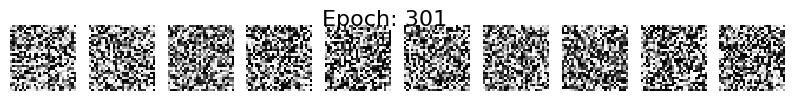

Epoch: 301/1000, D Loss: 3.943626880645752, G Loss: [array(3.9484775, dtype=float32), array(3.9484775, dtype=float32), array(0.30018428, dtype=float32)]
Epoch: 301/1000, D Loss: 3.943626880645752, G Loss: [array(3.9484775, dtype=float32), array(3.9484775, dtype=float32), array(0.30018428, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 302/1000, D Loss: 3.9480032920837402, G Loss: [array(3.952872, dtype=float32), array(3.952872, dtype=float32), array(0.30003104, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch: 303/1000, D Loss: 3.9523282051086426, G Loss: [array(3.9571106, dtype=float32), array(3.9571106, dtype=float32), array(0.2999304, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 304/1000, D Loss: 3.9566216468811035, G Loss: [array(3.9614925, dtype=float32), array(3.9614925, dtype=float32), array(0.29986894, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 305/1000, D Loss: 3.960873603820801, G Loss: [array(3.965625, dtype=float32)

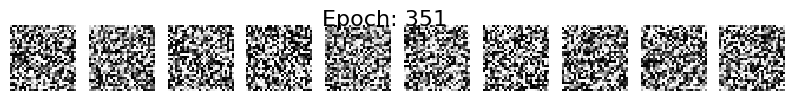

Epoch: 351/1000, D Loss: 4.131158828735352, G Loss: [array(4.1352415, dtype=float32), array(4.1352415, dtype=float32), array(0.29634082, dtype=float32)]
Epoch: 351/1000, D Loss: 4.131158828735352, G Loss: [array(4.1352415, dtype=float32), array(4.1352415, dtype=float32), array(0.29634082, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 352/1000, D Loss: 4.134256362915039, G Loss: [array(4.138149, dtype=float32), array(4.138149, dtype=float32), array(0.29633123, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 353/1000, D Loss: 4.137351989746094, G Loss: [array(4.141423, dtype=float32), array(4.141423, dtype=float32), array(0.29626638, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 354/1000, D Loss: 4.140398025512695, G Loss: [array(4.1442094, dtype=float32), array(4.1442094, dtype=float32), array(0.29616877, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 355/1000, D Loss: 4.143503665924072, G Loss: [array(4.1475406, dtype=float32), a

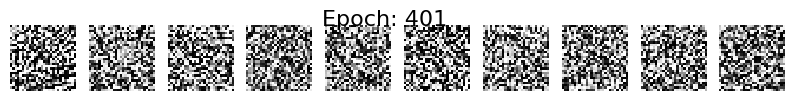

Epoch: 401/1000, D Loss: 4.278778076171875, G Loss: [array(4.2823205, dtype=float32), array(4.2823205, dtype=float32), array(0.2937578, dtype=float32)]
Epoch: 401/1000, D Loss: 4.278778076171875, G Loss: [array(4.2823205, dtype=float32), array(4.2823205, dtype=float32), array(0.2937578, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch: 402/1000, D Loss: 4.281412124633789, G Loss: [array(4.2848535, dtype=float32), array(4.2848535, dtype=float32), array(0.29364893, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 403/1000, D Loss: 4.284092903137207, G Loss: [array(4.287755, dtype=float32), array(4.287755, dtype=float32), array(0.2935503, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch: 404/1000, D Loss: 4.286625862121582, G Loss: [array(4.289868, dtype=float32), array(4.289868, dtype=float32), array(0.29350054, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 405/1000, D Loss: 4.28883171081543, G Loss: [array(4.2922826, dtype=float32), array

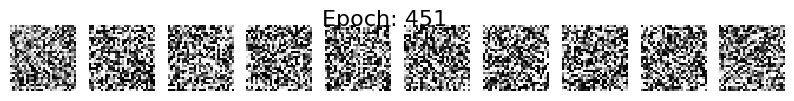

Epoch: 451/1000, D Loss: 4.403533935546875, G Loss: [array(4.406821, dtype=float32), array(4.406821, dtype=float32), array(0.29216325, dtype=float32)]
Epoch: 451/1000, D Loss: 4.403533935546875, G Loss: [array(4.406821, dtype=float32), array(4.406821, dtype=float32), array(0.29216325, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 452/1000, D Loss: 4.405947685241699, G Loss: [array(4.4091554, dtype=float32), array(4.4091554, dtype=float32), array(0.29211318, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch: 453/1000, D Loss: 4.408227920532227, G Loss: [array(4.4114094, dtype=float32), array(4.4114094, dtype=float32), array(0.29214093, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch: 454/1000, D Loss: 4.410406589508057, G Loss: [array(4.4134746, dtype=float32), array(4.4134746, dtype=float32), array(0.29216856, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 455/1000, D Loss: 4.412641525268555, G Loss: [array(4.415865, dtype=float32), ar

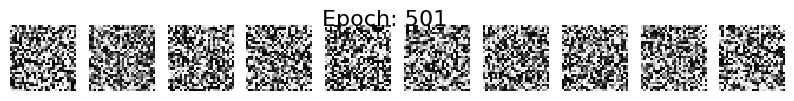

Epoch: 501/1000, D Loss: 4.510204315185547, G Loss: [array(4.5131435, dtype=float32), array(4.5131435, dtype=float32), array(0.2905595, dtype=float32)]
Epoch: 501/1000, D Loss: 4.510204315185547, G Loss: [array(4.5131435, dtype=float32), array(4.5131435, dtype=float32), array(0.2905595, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 502/1000, D Loss: 4.51231575012207, G Loss: [array(4.5152864, dtype=float32), array(4.5152864, dtype=float32), array(0.29059544, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 503/1000, D Loss: 4.514455795288086, G Loss: [array(4.517413, dtype=float32), array(4.517413, dtype=float32), array(0.29058462, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 504/1000, D Loss: 4.5165114402771, G Loss: [array(4.5193477, dtype=float32), array(4.5193477, dtype=float32), array(0.2905351, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch: 505/1000, D Loss: 4.518374443054199, G Loss: [array(4.521178, dtype=float32), array(

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 538/1000, D Loss: 4.5799970626831055, G Loss: [array(4.5827994, dtype=float32), array(4.5827994, dtype=float32), array(0.28964335, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch: 539/1000, D Loss: 4.5819854736328125, G Loss: [array(4.5847983, dtype=float32), array(4.5847983, dtype=float32), array(0.2897075, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 540/1000, D Loss: 4.583769798278809, G Loss: [array(4.5863237, dtype=float32), array(4.5863237, dtype=float32), array(0.28967014, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 541/1000, D Loss: 4.585354804992676, G Loss: [array(4.5879273, dtype=float32), array(4.5879273, dtype=float32), array(0.28964013, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 542/1000, D Loss: 4.587093830108643, G Loss: [array(4.589895, dtype=float32), array(4.589895, dtype=float32), array(0.2896679, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 54

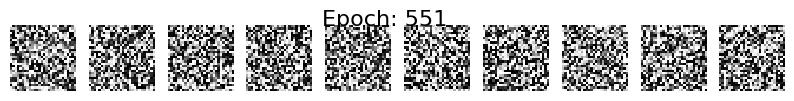

Epoch: 551/1000, D Loss: 4.603688716888428, G Loss: [array(4.6062217, dtype=float32), array(4.6062217, dtype=float32), array(0.28947368, dtype=float32)]
Epoch: 551/1000, D Loss: 4.603688716888428, G Loss: [array(4.6062217, dtype=float32), array(4.6062217, dtype=float32), array(0.28947368, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch: 552/1000, D Loss: 4.605521202087402, G Loss: [array(4.60836, dtype=float32), array(4.60836, dtype=float32), array(0.28950125, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 553/1000, D Loss: 4.607476234436035, G Loss: [array(4.610098, dtype=float32), array(4.610098, dtype=float32), array(0.28945807, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch: 554/1000, D Loss: 4.609081745147705, G Loss: [array(4.61162, dtype=float32), array(4.61162, dtype=float32), array(0.28947145, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 555/1000, D Loss: 4.610772609710693, G Loss: [array(4.613406, dtype=float32), array(4.

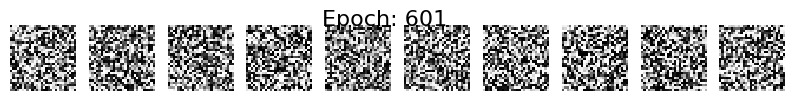

Epoch: 601/1000, D Loss: 4.690110206604004, G Loss: [array(4.6925297, dtype=float32), array(4.6925297, dtype=float32), array(0.28814605, dtype=float32)]
Epoch: 601/1000, D Loss: 4.690110206604004, G Loss: [array(4.6925297, dtype=float32), array(4.6925297, dtype=float32), array(0.28814605, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch: 602/1000, D Loss: 4.691617965698242, G Loss: [array(4.6940227, dtype=float32), array(4.6940227, dtype=float32), array(0.2881281, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch: 603/1000, D Loss: 4.6931586265563965, G Loss: [array(4.695576, dtype=float32), array(4.695576, dtype=float32), array(0.28810376, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 604/1000, D Loss: 4.6946516036987305, G Loss: [array(4.69703, dtype=float32), array(4.69703, dtype=float32), array(0.28808594, dtype=float32)]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch: 605/1000, D Loss: 4.6960577964782715, G Loss: [array(4.6983905, dtype=float32), a

In [ ]:
# GAN 학습 루프
for epoch in range(epochs):
    # 진짜 이미지와 가짜 이미지 생성
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_images = X_train[idx]

    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
    generated_images = generator.predict(noise)

    # 가짜 이미지의 형태를 맞추기
    generated_images = np.expand_dims(generated_images, axis=-1)  # 형태: (batch_size, 28, 28, 1)

    # 판별자 학습
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    d_loss_real = discriminator.train_on_batch(real_images, real_labels)
    d_loss_fake = discriminator.train_on_batch(generated_images, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # 생성자 학습
    noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
    g_loss = gan_input.train_on_batch(noise, real_labels)

    # 50 에폭마다 이미지 저장 및 실시간 표시
    if epoch % 50 == 0:
        save_and_show_generated_images(epoch)
    
    # 현재 에폭과 손실 출력
    print(f'Epoch: {epoch + 1}/{epochs}, D Loss: {d_loss[0]}, G Loss: {g_loss}')
